<a href="https://colab.research.google.com/github/ChoBazzi/ktb_AI/blob/main/ktb_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 77.1 MB/s eta 0:00:00


In [ ]:
# Colab 노트북에 이 코드를 셀별로 복사하여 실행하세요.

#################################################################
## 1. 환경 설정 및 데이터 다운로드 (Colab 임시 저장소)
#################################################################

import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# 1. Kaggle API 키 설정
# (Colab '파일' 탭에 'kaggle.json'을 미리 업로드해야 합니다)
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # /content/kaggle.json -> ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# 2. Colab 임시 저장소에 경로 설정
base_dir = '/content/natural_scenes'
data_dir = os.path.join(base_dir, 'data') # 압축 풀 데이터 경로
model_save_dir = os.path.join(base_dir, 'models') # 모델 저장 경로

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_save_dir, exist_ok=True)

print(f"데이터셋 다운로드 경로: {base_dir}")
print(f"모델 저장 경로: {model_save_dir}")

# 3. Kaggle 데이터셋을 Colab 경로(-p)에 다운로드
!kaggle datasets download -d puneet6060/intel-image-classification -p {base_dir}

# 4. Colab 경로에 있는 zip 파일을 Colab 경로(-d)에 압축 해제
zip_path = os.path.join(base_dir, 'intel-image-classification.zip')
!unzip -q {zip_path} -d {data_dir}

print("Colab 임시 저장소에 데이터 준비 완료.")

데이터셋 다운로드 경로: /content/natural_scenes
모델 저장 경로: /content/natural_scenes/models
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 336M/346M [00:00<00:00, 1.76GB/s]
100% 346M/346M [00:00<00:00, 1.75GB/s]
Colab 임시 저장소에 데이터 준비 완료.


In [ ]:
# 기본 변수 설정
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Colab 임시 저장소 경로 설정
train_dir = os.path.join(data_dir, 'seg_train/seg_train')
test_dir = os.path.join(data_dir, 'seg_test/seg_test')

# 모델 저장 파일 경로
fe_model_path = os.path.join(model_save_dir, 'resnet_fe_best_model.h5')
ft_model_path = os.path.join(model_save_dir, 'resnet_ft_best_model.h5')

In [ ]:
# 1. 훈련/검증 데이터 로드 (train_dir에서 20%를 validation으로 분리)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical', # 6개 클래스
    validation_split=0.2,     # 훈련 데이터의 20%를 검증용으로 사용
    subset='both',            # 훈련(training)과 검증(validation) 세트 모두 반환
    seed=123
)

# 2. 테스트 데이터 로드
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
print("클래스:", class_names)

# 3. 데이터 증강(Augmentation) 레이어 정의
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="augmentation")

# 4. ResNet50 전용 전처리 적용
def apply_resnet_preprocessing(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(apply_resnet_preprocessing).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(apply_resnet_preprocessing).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(apply_resnet_preprocessing).prefetch(tf.data.AUTOTUNE)

# 5. 시각화 함수 정의
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.suptitle(title, fontsize=16)
    plt.show()

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
클래스: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']



--- 실험 1: Feature Extraction (ResNet50) 시작 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7391 - loss: 0.7119
Epoch 1: val_loss improved from inf to 0.22410, saving model to /content/natural_scenes/models/resnet_fe_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.7393 - loss: 0.7112 - val_accuracy: 0.9184 - val_loss: 0.2241
Epoch 2/25
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8876 - loss: 0.3250
Epoch 2: val_loss improved from 0.22410 to 0.20890, saving model to /content/natural_scenes/models/resnet_fe_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.8876 - loss: 0.3250 - val_accuracy: 0.9212 - val_loss: 0.2089
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8926 - loss: 0.3037
Epoch 3: val_loss did not improve from 0.20890
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8926 - loss: 0.3037 - val_accuracy: 0.9241 - val_loss: 0.2108
Epoch 4/25
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8926 - loss: 0.3034
Epoch 4: val_loss did not improve from 0.20890
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8926 - loss: 0.3033 - val_accuracy: 0.9266 - val_loss: 0.2110
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8919 - loss: 0.2959
Epoch 5: val_loss improved from 0.20890 to 0.20683, saving model to /content/natural_scenes/models/resnet_fe_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.8919 - loss: 0.2958 - val_accuracy: 0.9294 - val_loss: 0.2068
Epoch 6/25
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9003 - loss: 0.2790
Epoch 6: val_loss did not improve from 0.20683
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9003 - loss: 0.2790 - val_accuracy: 0.9227 - val_loss: 0.2186
Epoch 7/25
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9002 - loss: 0.2855
Epoch 7: val_loss did not improve from 0.20683
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9002 - loss: 0.2854 - val_accuracy: 0.9230 - val_loss: 0.2273
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9005 - loss: 0.2763
Epoch 8: val_loss did not improve from 0.20683
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9005 - loss: 0.2763 - val_accuracy: 0.9248 - val_loss: 0.2127
Epoch 9/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8985 - loss: 0.2802
Epoch 9: val_loss did not improve f

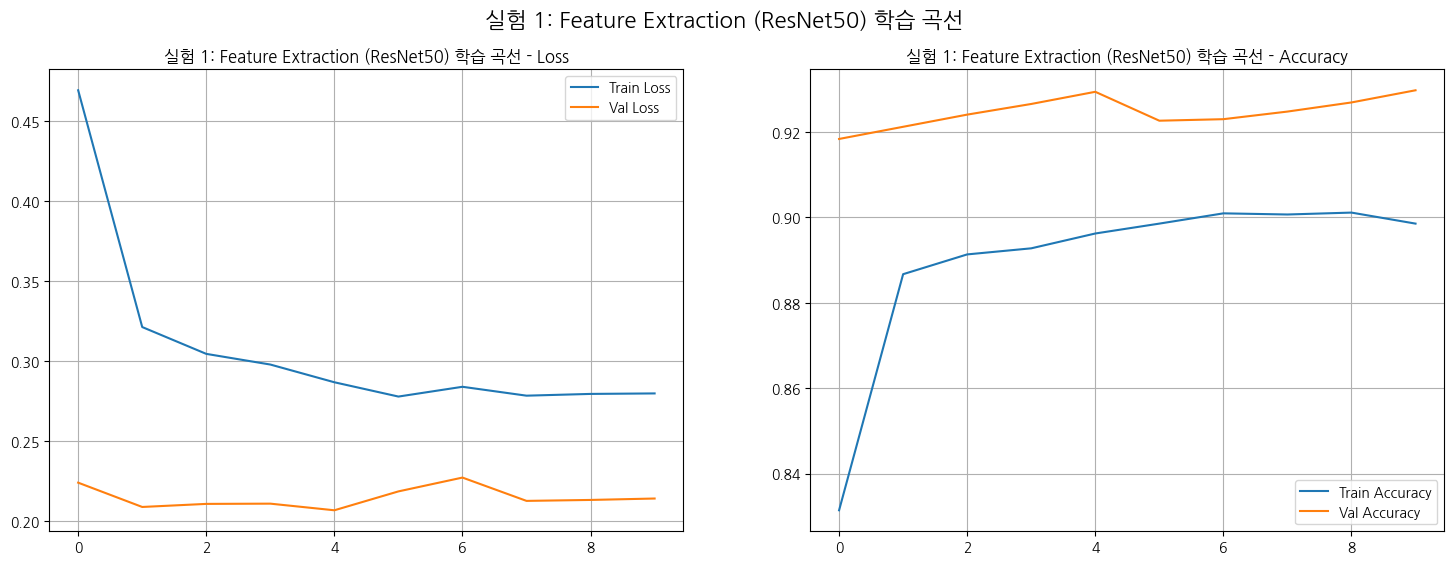

In [ ]:
print("\n--- 실험 1: Feature Extraction (ResNet50) 시작 ---")

# 1. ResNet50 기본 모델 로드
base_model_fe = ResNet50(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

# 2. 기본 모델 동결
base_model_fe.trainable = False

# 3. 새로운 분류기(Head) 추가
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model_fe(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)
model_fe = Model(inputs, outputs)

# 4. 모델 컴파일
model_fe.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 5. 콜백 정의 (Colab 임시 경로에 저장)
callbacks_fe = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath=fe_model_path,  # <-- /content/natural_scenes/models/...
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1)
]

# 6. 모델 훈련
history_fe = model_fe.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_fe
)

# 7. 시각화
print("--- 실험 1: Feature Extraction (ResNet50) 완료 ---")
plot_history(history_fe, "실험 1: Feature Extraction (ResNet50) 학습 곡선")


--- 실험 2: Fine-Tuning (ResNet50) 시작 ---


'conv5_block1_0_conv' 레이어부터 동결 해제 완료.
Epoch 11/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8617 - loss: 0.4025
Epoch 11: val_loss improved from inf to 0.21768, saving model to /content/natural_scenes/models/resnet_ft_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.8618 - loss: 0.4024 - val_accuracy: 0.9294 - val_loss: 0.2177 - learning_rate: 1.0000e-05
Epoch 12/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8966 - loss: 0.2926
Epoch 12: val_loss improved from 0.21768 to 0.21245, saving model to /content/natural_scenes/models/resnet_ft_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8966 - loss: 0.2925 - val_accuracy: 0.9330 - val_loss: 0.2124 - learning_rate: 1.0000e-05
Epoch 13/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9105 - loss: 0.2567
Epoch 13: val_loss improved from 0.21245 to 0.20819, saving model to /content/natural_scenes/models/resnet_ft_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9105 - loss: 0.2567 - val_accuracy: 0.9341 - val_loss: 0.2082 - learning_rate: 1.0000e-05
Epoch 14/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9204 - loss: 0.2363
Epoch 14: val_loss improved from 0.20819 to 0.20412, saving model to /content/natural_scenes/models/resnet_ft_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9204 - loss: 0.2362 - val_accuracy: 0.9355 - val_loss: 0.2041 - learning_rate: 1.0000e-05
Epoch 15/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9225 - loss: 0.2158
Epoch 15: val_loss improved from 0.20412 to 0.20140, saving model to /content/natural_scenes/models/resnet_ft_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9225 - loss: 0.2157 - val_accuracy: 0.9383 - val_loss: 0.2014 - learning_rate: 1.0000e-05
Epoch 16/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9243 - loss: 0.2198
Epoch 16: val_loss improved from 0.20140 to 0.19840, saving model to /content/natural_scenes/models/resnet_ft_best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9243 - loss: 0.2197 - val_accuracy: 0.9405 - val_loss: 0.1984 - learning_rate: 1.0000e-05
Epoch 17/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9312 - loss: 0.1901
Epoch 17: val_loss did not improve from 0.19840
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9312 - loss: 0.1901 - val_accuracy: 0.9405 - val_loss: 0.1997 - learning_rate: 1.0000e-05
Epoch 18/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9437 - loss: 0.1691
Epoch 18: val_loss did not improve from 0.19840

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9437 - loss: 0.1691 - val_accuracy: 0.9362 - val_loss: 0.1993 - learning_rate: 1.0000e-05
Epoch 19/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9411 - loss: 0.1503
Epoch 19: val_loss improved from 0.19840 to 0.19820, saving model to /content/natural_scenes/models/resnet_ft_best_model

351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9411 - loss: 0.1502 - val_accuracy: 0.9383 - val_loss: 0.1982 - learning_rate: 2.0000e-06
Epoch 20/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9420 - loss: 0.1547
Epoch 20: val_loss did not improve from 0.19820
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9420 - loss: 0.1547 - val_accuracy: 0.9394 - val_loss: 0.1989 - learning_rate: 2.0000e-06
Epoch 21/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9433 - loss: 0.1475
Epoch 21: val_loss did not improve from 0.19820

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9433 - loss: 0.1475 - val_accuracy: 0.9387 - val_loss: 0.1997 - learning_rate: 2.0000e-06
Epoch 22/30
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9426 - loss: 0.1514
Epoch 22: val_loss did not improve from 0.19820
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9426 - loss: 0.1

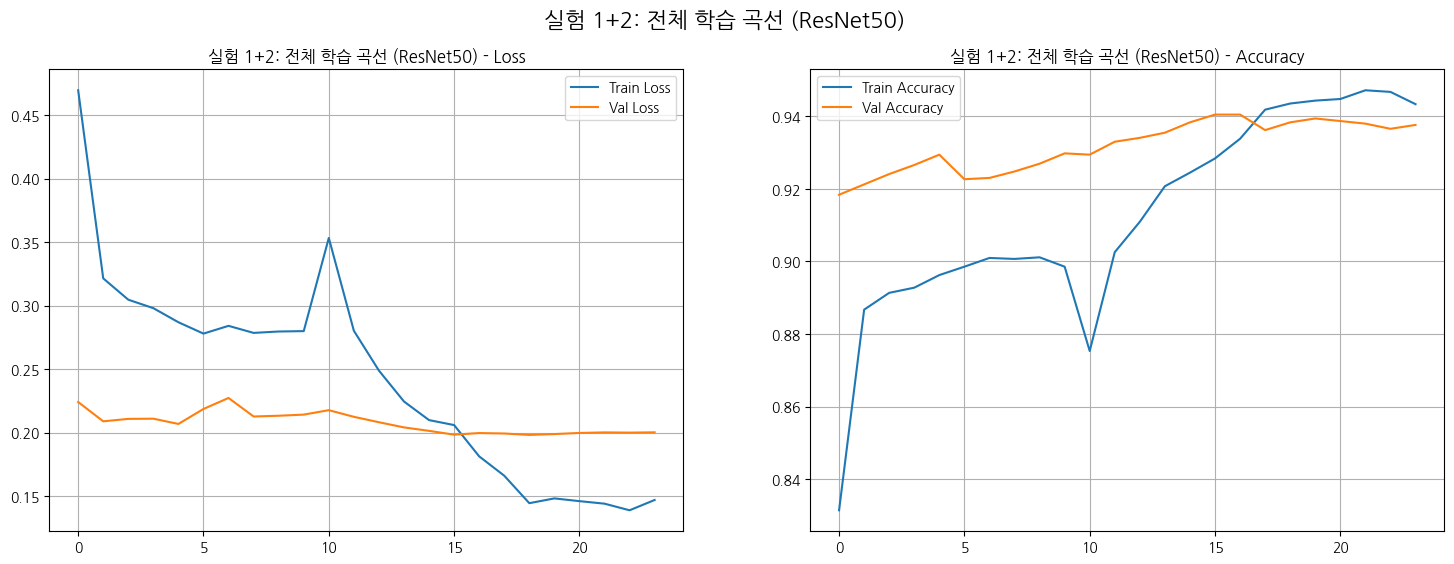

In [ ]:
print("\n--- 실험 2: Fine-Tuning (ResNet50) 시작 ---")

# 1. Colab 임시 저장소에서 실험 1의 최고 모델 로드
model_ft = tf.keras.models.load_model(fe_model_path)

# 2. ResNet50 베이스 모델 동결 해제
base_model_ft = model_ft.layers[2] # (Input -> Aug -> ResNet)
base_model_ft.trainable = True

# 3. 'conv5_block1' 블록(마지막 스테이지)부터 재학습
fine_tune_at_layer = 'conv5_block1_0_conv'
freeze_until_layer_found = True

for layer in base_model_ft.layers:
    if layer.name == fine_tune_at_layer:
        freeze_until_layer_found = False
    if freeze_until_layer_found:
        layer.trainable = False
print(f"'{fine_tune_at_layer}' 레이어부터 동결 해제 완료.")

# 4. 매우 낮은 학습률로 모델 재컴파일
model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 5. 콜백 정의 (Colab 임시 경로에 저장)
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath=ft_model_path, # <-- /content/natural_scenes/models/...
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,
                      patience=2,
                      min_lr=1e-7,
                      verbose=1)
]

# 6. 모델 훈련
initial_epoch = history_fe.epoch[-1] + 1
fine_tune_epochs = initial_epoch + 20

history_ft = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks_ft
)

# 7. 시각화
print("--- 실험 2: Fine-Tuning (ResNet50) 완료 ---")
history_full = {
    'loss': history_fe.history['loss'] + history_ft.history['loss'],
    'val_loss': history_fe.history['val_loss'] + history_ft.history['val_loss'],
    'accuracy': history_fe.history['accuracy'] + history_ft.history['accuracy'],
    'val_accuracy': history_fe.history['val_accuracy'] + history_ft.history['val_accuracy'],
}
plot_history(type('obj', (object,), {'history': history_full}), "실험 1+2: 전체 학습 곡선 (ResNet50)")

In [ ]:
print("\n--- 최종 평가 (Test Set, ResNet50) ---")

# 1. Colab 임시 저장소에서 FE 모델 로드
model_fe.load_weights(fe_model_path)
fe_results = model_fe.evaluate(test_ds, verbose=0)

# 2. Colab 임시 저장소에서 FT 모델 로드
model_ft.load_weights(ft_model_path)
ft_results = model_ft.evaluate(test_ds, verbose=0)

# 3. 보고서용 성능 비교표 출력
print("\n============= 최종 성능 비교 (Test Set, ResNet50) =============")
print(f"평가 지표: [Loss, Accuracy]")
print("---------------------------------------------------------------")
print(f"실험 1 (FE):  [{fe_results[0]:.4f}, {fe_results[1]:.4f}]")
print(f"실험 2 (FT):  [{ft_results[0]:.4f}, {ft_results[1]:.4f}]")
print("===============================================================")
print("\n(!) 훈련이 완료되면 Colab '파일' 탭에서")
print(f"{ft_model_path} 파일을 찾아 PC로 다운로드하세요.")


--- 최종 평가 (Test Set, ResNet50) ---

============= 최종 성능 비교 (Test Set, ResNet50) =============
평가 지표: [Loss, Accuracy]
---------------------------------------------------------------
실험 1 (FE):  [0.2182, 0.9223]
실험 2 (FT):  [0.1938, 0.9330]

(!) 훈련이 완료되면 Colab '파일' 탭에서
/content/natural_scenes/models/resnet_ft_best_model.h5 파일을 찾아 PC로 다운로드하세요.
